# In Depth: k-Means Clustering
# 深入：K均值聚類

聚類是一個過程，通過該過程您可以根據它們之間的距離將大量數據點收集到較少數量的組中。在數據量很大並且您想提取一些感興趣的數字的情況下，它很有用。它是一種無監督學習。聚類的一個常見用途是識別群體的不同子集，例如在人口普查中。有許多算法可用於執行聚類，最簡單和最常見的是 k 均值聚類。

- 讓我們首先使用 scikit-learn 為我們提供一些隨機生成的數據點。make_blobs()創建了許多Gaussian clusters。
- 我們將要求它在 4 個集群中創建 500 個點。 我們設置 random_state=6 以確保此示例將始終生成相同的可重現點。

<AxesSubplot:xlabel='x1', ylabel='x2'>

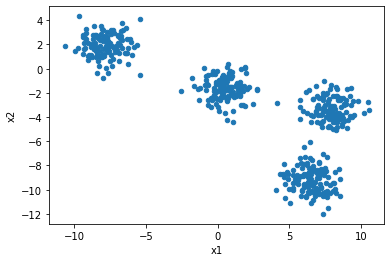

In [1]:
%matplotlib inline

import pandas as pd
from sklearn.datasets import make_blobs
data, true_labels = make_blobs(n_samples=500, centers=4, random_state=6)

points = pd.DataFrame(data, columns=["x1", "x2"])
points.plot.scatter("x1", "x2")

<AxesSubplot:xlabel='x1', ylabel='x2'>

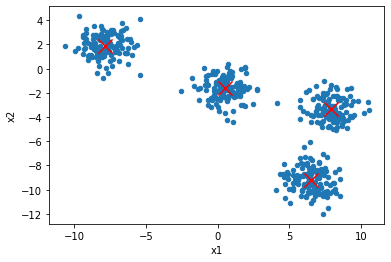

In [2]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4).fit(points)
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=["x1", "x2"])
ax = points.plot.scatter("x1", "x2")
cluster_centers.plot.scatter("x1", "x2", ax=ax, c="red", s=200, marker="x")

<AxesSubplot:xlabel='x1', ylabel='x2'>

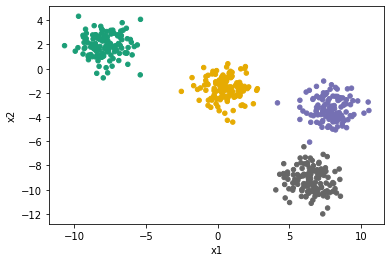

In [3]:
points.plot.scatter("x1", "x2", c=kmeans.labels_, colormap="Dark2", colorbar=False)

### 關於 Kmeans


> In the previous few sections, we have explored one category of unsupervised machine learning models: dimensionality reduction.Here we will move on to another class of unsupervised machine learning models: clustering algorithms.
Clustering algorithms seek to learn, from the properties of the data, an optimal division or discrete labeling of groups of points.The *k*-means algorithm searches for a pre-determined number of clusters within an unlabeled multidimensional dataset.
It accomplishes this using a simple conception of what the optimal clustering looks like:

無監督機器學習兩個大類：降維(前幾章)、聚類算法(本章)。聚類算法尋求通過數據的屬性進行學習，然後獲得數據點的優化分組或離散標籤。K均值是一個在未標記的多維數據集中尋找確定分組數聚類的算法。該算法基於下述的優化聚類的基本概念，這兩個假設是k均值模型的基本原理：

- 聚類中心是該聚類所有點的算術平均。
- 每一個數據點距離它所屬的聚類中心比距離其他聚類中心都要近。

> First, let's generate a two-dimensional dataset containing four distinct blobs.

首先，讓我們生成一個二維的數據集，內含四個獨立的群落。

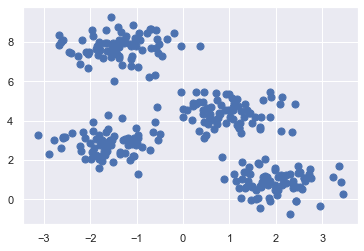

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

> By eye, it is relatively easy to pick out the four clusters.The *k*-means algorithm does this automatically:Let's visualize the results by plotting the data colored by these labels. We will also plot the cluster centers as determined by the *k*-means estimator:

通過肉眼觀察很容易能分出四個聚類出來。 k均值算法會自動完成這個工作，將模型預測的結果使用不同的顏色繪製在圖中。同時我們也會在圖中畫出每個聚類的中心點，這個中心點是評估器計算得到的：

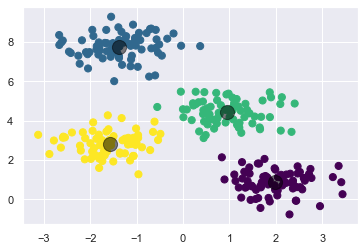

In [5]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
#plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5, marker ='*')

> The good news is that the *k*-means algorithm (at least in this simple case) assigns the points to clusters very similarly to how we might assign them by eye.
But you might wonder how this algorithm finds these clusters so quickly! After all, the number of possible combinations of cluster assignments is exponential in the number of data points—an exhaustive search would be very, very costly.
Fortunately for us, such an exhaustive search is not necessary: instead, the typical approach to *k*-means involves an intuitive iterative approach known as *expectation–maximization*.

可以看到k均值算法（至少在這個簡單的例子當中）對數據點聚類的方法與肉眼方式相似。但是你可能會疑惑為什麼算法能這麼快找出所有的聚類。因為由簡單的數學可知，聚類的可能數量是數據點數量的指數量級。如果窮舉所有的可能性的話，那將會非常非常慢。幸運的是，我們並不需要這樣的窮舉：可以使用一種被稱為最大期望算法的直觀迭代方法來實現k均值算法。

## k-Means Algorithm: Expectation–Maximization (EM)

## k均值算法：最大期望算法

> Expectation–maximization (E–M) is a powerful algorithm that comes up in a variety of contexts within data science.
*k*-means is a particularly simple and easy-to-understand application of the algorithm, and we will walk through it briefly here.Here the "E-step" or "Expectation step" is so-named because it involves updating our expectation of which cluster each point belongs to.The "M-step" or "Maximization step" is so-named because it involves maximizing some fitness function that defines the location of the cluster centers—in this case, that maximization is accomplished by taking a simple mean of the data in each cluster.In short, the expectation–maximization approach here consists of the following procedure:

最大期望算法（E-M）是在數據科學領域廣泛應用的強大算法。其中k均值是該算法最簡單和易於理解的應用場景，最大期望算法的步驟如下：

1. 隨機猜測聚類中心點
2. ---重複以下步驟---
3. *E步驟(期望步驟)*：將所有數據點分配到最近的聚類中心點上，處理每個數據點歸屬的聚類的，即我們的期望。
4. *M步驟(最大化步驟)*：重新計算每個聚類的中心點，定義聚類中心點適配函數，對每個聚類的數據點取均值。

> The literature about this algorithm is vast, but can be summarized as follows: under typical circumstances, each repetition of the E-step and M-step will always result in a better estimate of the cluster characteristics.We can visualize the algorithm as shown in the following figure. For the particular initialization shown here, the clusters converge in just three iterations.

要詳細描述整個算法可能會很冗長，但是可以用一句話進行概括：在典型情況下，每次E步驟和M步驟的迭代都會導致更加準確的聚類特徵結果。我們可以用下面圖像可視化這個算法過程。對於一個左邊圖中設定的初始化中心點的情況，算法僅需要三次迭代的過程就可以完成聚類結果。

![(run code in Appendix to generate image)](figures/05.11-expectation-maximization.png)
[附录中生成图像的代码](06.00-Figure-Code.ipynb#Expectation-Maximization)

> The *k*-Means algorithm is simple enough that we can write it in a few lines of code.
The following is a very basic implementation:

k均值算法很簡單，我們可以使用數行代碼就能實現它。下面是一種最基本的實現方式：

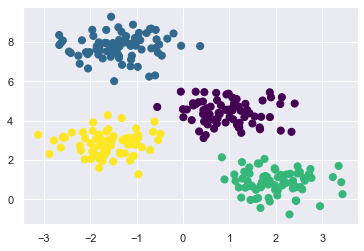

In [6]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. 隨機選取聚類中心點
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. 計算求出距離最近的中心點，標記相應數據點
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. 求出每個聚類最新的中心點
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. 檢查收斂，如果新中心點與原中心點相同，算法結束
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

#### The globally optimal result may not be achieved 全局最優解可能不可得

> First, although the E–M procedure is guaranteed to improve the result in each step, there is no assurance that it will lead to the *global* best solution.
For example, if we use a different random seed in our simple procedure, the particular starting guesses lead to poor results: Here the E–M approach has converged, but has not converged to a globally optimal configuration. For this reason, it is common for the algorithm to be run for multiple starting guesses, as indeed Scikit-Learn does by default (set by the ``n_init`` parameter, which defaults to 10).

雖然E-M算法能保證每次迭代都改善結果，但是它並不能保證最終會產生全局最優解。例如使用不同的隨機種子，這個初始化值可能會產生不良的結果：例子中E-M算法已經收斂了，但是沒有收斂到最優的結果。因此該算法需要在不同的初始化條件下運行多次，而事實上Scikit-Learn默認就會這樣做（設置`n_init`參數，默認為10）。

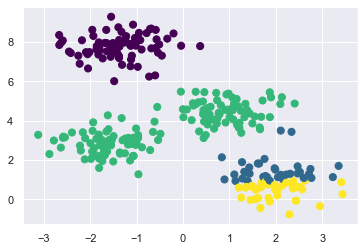

In [7]:
centers, labels = find_clusters(X, 4, rseed=0)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

#### The number of clusters must be selected beforehand 聚類的數量必須預先選擇

> Another common challenge with *k*-means is that you must tell it how many clusters you expect: it cannot learn the number of clusters from the data.
For example, if we ask the algorithm to identify six clusters, it will happily proceed and find the best six clusters:

k均值算法的另一個常見挑戰是你必須告訴它聚類的個數：它並不能夠從數據中學習得到聚類的數量。例如我們要求算法計算6個聚類，它會很成功的運行得到相應的結果：

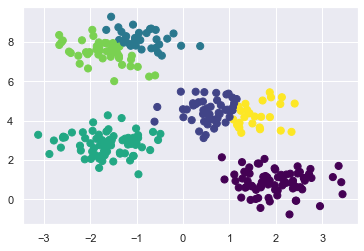

In [8]:
labels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

> Whether the result is meaningful is a question that is difficult to answer definitively; one approach that is rather intuitive, but that we won't discuss further here, is called [silhouette analysis](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html).Alternatively, you might use a more complicated clustering algorithm which has a better quantitative measure of the fitness per number of clusters (Gaussian mixture models; see [In Depth: Gaussian Mixture Models](05.12-Gaussian-Mixtures.ipynb)) or which *can* choose a suitable number of clusters (DBSCAN, mean-shift, or affinity propagation, all available in the ``sklearn.cluster`` submodule)

產生的結果是否有意義通常是一個難以準確回答的問題；有一種比較直觀的方法可以回答這個問題，叫做[輪廓分析](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)，我們這裡不會詳述。還有其他的選擇，你可以使用更加複雜的聚類算法，它們能提供更好的數值度量，如聚類的數量（高斯混合模型，參見[深入：高斯混合模型](05.12-Gaussian-Mixtures.ipynb)），或者*能夠*選擇合適的聚類的數量（密度聚類DBSCAN，均值漂移mean-shift，親和力傳播affinity propagation，它們都實現在`sklearn.cluster`）。

#### k-means is limited to linear cluster boundaries k均值只限於線性聚類邊界

> The fundamental model assumptions of *k*-means (points will be closer to their own cluster center than to others) means that the algorithm will often be ineffective if the clusters have complicated geometries.In particular, the boundaries between *k*-means clusters will always be linear, which means that it will fail for more complicated boundaries.

k均值的基本模型假設（數據點距離它所屬的中心點比其他中心點都要近）意味著這個算法通常會在聚類有著複雜的集合結構的情況下失效。嚴格來說，k均值算法聚類的邊界總是線性的，因此在更複雜邊界的情況下將無法使用

In [9]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

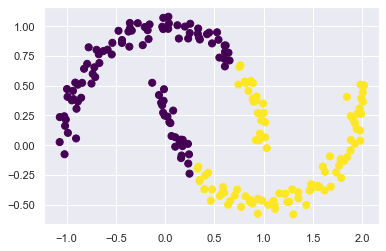

In [10]:
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

> This situation is reminiscent of the discussion in [In-Depth: Support Vector Machines](05.07-Support-Vector-Machines.ipynb), where we used a kernel transformation to project the data into a higher dimension where a linear separation is possible.We might imagine using the same trick to allow *k*-means to discover non-linear boundaries.One version of this kernelized *k*-means is implemented in Scikit-Learn within the ``SpectralClustering`` estimator.It uses the graph of nearest neighbors to compute a higher-dimensional representation of the data, and then assigns labels using a *k*-means algorithm:

這種情形讓我們想起在[深入：支持向量機](05.07-Support-Vector-Machines.ipynb)中的討論，我們可以使用核轉換將數據投射到更高的維度上，令線性分類器可以工作。我們也可以在k均值算法上使用相同的技巧，令k均值能夠支持非線性的邊界。這種k均值算法其中一個版本是`SpectralClustering`評估器。它使用最近鄰圖像來計算更高維度的數據表示，然後使用k均值算法來標記數據點：

/Users/jerrychien/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


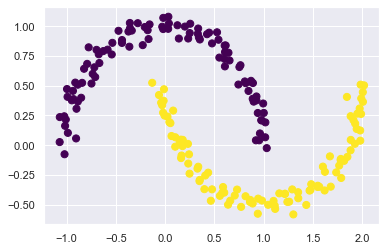

In [11]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,s=50, cmap='viridis')

#### k-means can be slow for large numbers of samples k均值在大數據集上很慢

> Because each iteration of *k*-means must access every point in the dataset, the algorithm can be relatively slow as the number of samples grows.
You might wonder if this requirement to use all data at each iteration can be relaxed; for example, you might just use a subset of the data to update the cluster centers at each step.
This is the idea behind batch-based *k*-means algorithms, one form of which is implemented in ``sklearn.cluster.MiniBatchKMeans``.
The interface for this is the same as for standard ``KMeans``; we will see an example of its use as we continue our discussion.

因為k均值算法上每次迭代都要獲取數據集中的每個點，當樣本量增加時，算法性能會下降。你可能會覺得是否每次迭代都有必要使用全部數據點；例如，每次迭代僅使用數據的一個子集來更新聚類中心點。這種想法就是基於批次的k均值算法，它被實現在`sklearn.cluster.MiniBatchKMeans`當中。

### Example 1: k-means on digits 手寫數字上應用k均值

> Here we will attempt to use *k*-means to try to identify similar digits *without using the original label information*; this might be similar to a first step in extracting meaning from a new dataset about which you don't have any *a priori* label information. We will start by loading the digits and then finding the ``KMeans`` clusters.
Recall that the digits consist of 1,797 samples with 64 features, where each of the 64 features is the brightness of one pixel in an 8×8 image:

我們將嘗試不使用原始標籤信息的情況下，應用k均值算法來分辨手寫的數字；這情況就像我們在遇到一個沒有任何初始標記的數據時，我們希望首先從中提取出有意義的信息一樣。當然我們需要載入數據然後找到其k均值聚類結果。回想一下，我們知道數據有1797個樣本，每個樣本有64個特徵，這些特征代表著8×8圖像中每個像素點的亮度：

In [12]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

> The clustering can be performed as we did before:

就像前面那樣，我們進行k均值聚類：

In [13]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

> The result is 10 clusters in 64 dimensions.
Notice that the cluster centers themselves are 64-dimensional points, and can themselves be interpreted as the "typical" digit within the cluster.
Let's see what these cluster centers look like:

結果是在64維空間中的10個聚類。注意每個聚類的中心點都是64維空間中的一個點，我們可以將它們看做每個聚類的“典型”數字。讓我們將這些中心點數字畫出來：

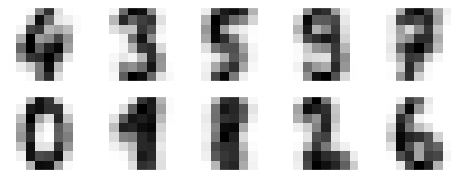

In [14]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

> We see that *even without the labels*, ``KMeans`` is able to find clusters whose centers are recognizable digits, with perhaps the exception of 1 and 8.Because *k*-means knows nothing about the identity of the cluster, the 0–9 labels may be permuted.We can fix this by matching each learned cluster label with the true labels found in them. Now we can check how accurate our unsupervised clustering was in finding similar digits within the data:

上面的結果表明，*甚至不需要標記*，`K均值`算法就已經能夠分出聚類，並且它們的中心點都是可以識別的數字，可能1和8稍微模糊點。因為k均值算法根本不知道這些聚類的標記，因此0-9的標籤不是按照順序排列的。我們可以將真實的標籤和學習到的聚類標籤進行對應後檢查這個無監督聚類算法結果的準確性：

In [15]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

In [16]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7935447968836951

> With just a simple *k*-means algorithm, we discovered the correct grouping for 80% of the input digits!
Let's check the confusion matrix for this:

通過一個簡單的k均值算法，我們就可以對80%左右的輸入數據進行正確的分組。讓我們再看看相應的混淆矩陣：

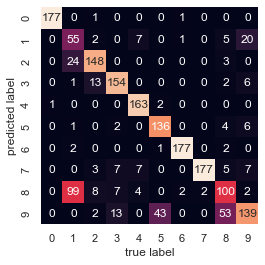

In [17]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)

plt.xlabel('true label')
plt.ylabel('predicted label');

> As we might expect from the cluster centers we visualized before, the main point of confusion is between the eights and ones.
But this still shows that using *k*-means, we can essentially build a digit classifier *without reference to any known labels*!

正如我們前面展示的聚類中心所預期到的那樣，主要混淆的地方是在處在數字8和數字1之間。但是這還是能證明我們使用k均值就能構建一個分類器，而*不需要參考任何已知的標籤*。

> Just for fun, let's try to push this even farther.
We can use the t-distributed stochastic neighbor embedding (t-SNE) algorithm (mentioned in [In-Depth: Manifold Learning](05.10-Manifold-Learning.ipynb)) to pre-process the data before performing *k*-means.
t-SNE is a nonlinear embedding algorithm that is particularly adept at preserving points within clusters.
Let's see how it does:That's nearly 92% classification accuracy *without using the labels*.
This is the power of unsupervised learning when used carefully: it can extract information from the dataset that it might be difficult to do by hand or by eye.

為了更加有趣一點，我們再繼續深入一點。我們使用t分佈隨機近鄰嵌入（t-SNE）算法（參見[深入：流形學習](05.10-Manifold-Learning.ipynb)）在k均值算法之前來對數據進行預處理。 t-SNE是一個非線性嵌入算法，特別適合用來保留聚類的數據點。讓我們來看看怎麼做：這能在*不使用標籤*的情況下達到超過93%的分類準確率。這體現了恰當的使用無監督學習方法的威力：它能從數據集中提取出關鍵信息，而這很難使用手工或肉眼完成。

In [18]:
from sklearn.manifold import TSNE

# 投射數據點，本步驟可能需要執行一段時間
tsne = TSNE(n_components=2, init='random', random_state=0)
digits_proj = tsne.fit_transform(digits.data)

# 計算聚類
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

# 排列標籤
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

# 計算準確率
accuracy_score(digits.target, labels)

/Users/jerrychien/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


0.9432387312186978

### Example 2: *k*-means for color compression k均值進行顏色壓縮

> One interesting application of clustering is in color compression within images.
For example, imagine you have an image with millions of colors.
In most images, a large number of the colors will be unused, and many of the pixels in the image will have similar or even identical colors.

聚類還有一個有趣的應用是在圖像的顏色壓縮領域。例如設想你有一張圖像包含一百萬種顏色。在大多數圖像中，大量的顏色都沒有被用到，並且圖像中很多的像素都有著相似甚至相同的顏色。

> For example, consider the image shown in the following figure, which is from the Scikit-Learn ``datasets`` module (for this to work, you'll have to have the ``pillow`` Python package installed).

例如下面這張圖像，是Scikit-Learn的`datasets`模塊自帶的（要使下面例子能成功運行，你需要安裝`pillow`包）。

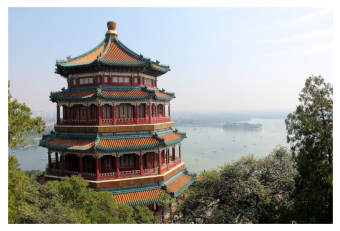

In [19]:
# 注：需要安装pillow包
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);

> The image itself is stored in a three-dimensional array of size ``(height, width, RGB)``, containing red/blue/green contributions as integers from 0 to 255:

這張圖像存儲在一個尺寸為`(高度, 寬度, RGB)`的三維數組之中，包含了紅/藍/綠的數值，取值範圍是0-255：

In [20]:
china.shape

(427, 640, 3)

> One way we can view this set of pixels is as a cloud of points in a three-dimensional color space.
We will reshape the data to ``[n_samples x n_features]``, and rescale the colors so that they lie between 0 and 1:

我們也可以將這張圖像的像素看成是一個三維顏色空間中的數據點集合。下面我們將數組變形為`[n_samples x n_features]`形狀，然後將顏色值轉換為取值範圍是0-1之間：

In [21]:
data = china / 255.0 # use 0...1 scale
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

> We can visualize these pixels in this color space, using a subset of 10,000 pixels for efficiency:

我們可以在這個顏色空間中將這些像素點可視化出來，為了效率起見，僅選擇10000個像素的子數據集：

In [22]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # 选择随机子数据集
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

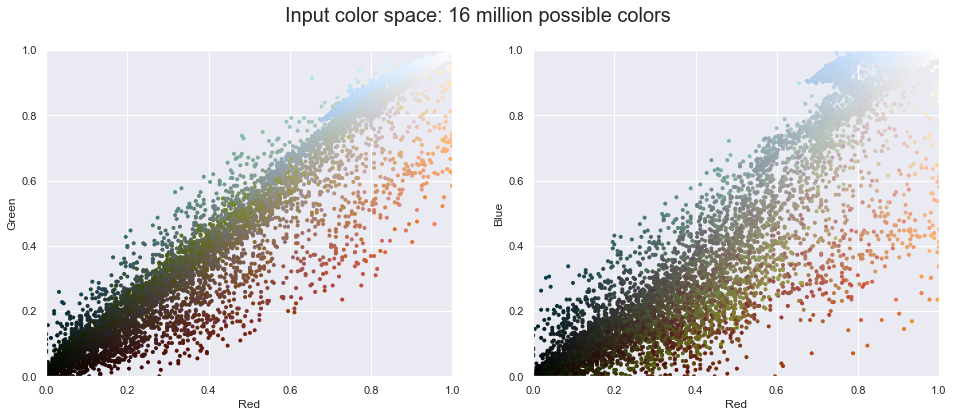

In [23]:
plot_pixels(data, title='Input color space: 16 million possible colors')

> Now let's reduce these 16 million colors to just 16 colors, using a *k*-means clustering across the pixel space.
Because we are dealing with a very large dataset, we will use the mini batch *k*-means, which operates on subsets of the data to compute the result much more quickly than the standard *k*-means algorithm:

下面我們將1600萬顏色調整為16色，僅僅需要在像素空間上使用k均值聚類算法。因為我們面對的是一個非常巨大的數據集，我們將會使用批次k均值算法，該算法每次迭代只會在數據子集上進行計算，比標準的k均值算法要快得多：

譯者註：下面的warning已經被Numpy修復，因此代碼中做了註釋。

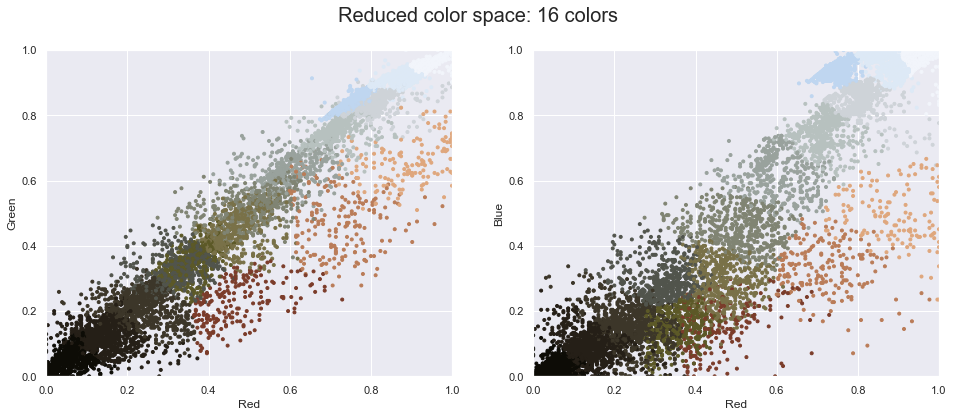

In [24]:
#import warnings; warnings.simplefilter('ignore')  # Fix NumPy issues.

from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,
            title="Reduced color space: 16 colors")

> The result is a re-coloring of the original pixels, where each pixel is assigned the color of its closest cluster center.
Plotting these new colors in the image space rather than the pixel space shows us the effect of this:

得到的結果是重新設置後的原始像素的顏色，也就是每個像素的顏色被設置成了它所屬聚類的中心點值。將這些新設置顏色的像素轉換回圖像空間，然後展示出來：

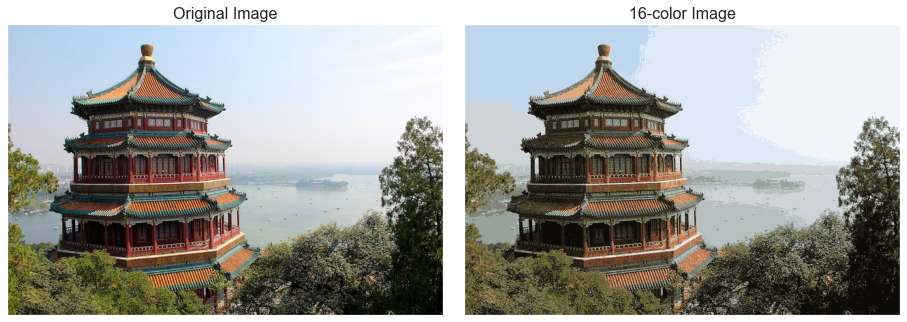

In [25]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16);

> Some detail is certainly lost in the rightmost panel, but the overall image is still easily recognizable.
This image on the right achieves a compression factor of around 1 million!
While this is an interesting application of *k*-means, there are certainly better way to compress information in images.
But the example shows the power of thinking outside of the box with unsupervised methods like *k*-means.

當然右圖中損失了一些細節，但整體上圖像還是很容易辨認的。運用這個方法右圖獲得了一個大約1百萬的壓縮比率。雖然這是k均值算法的一個有趣的應用場景，但是顯然壓縮圖像信息還有更好的方法。這個例子為我們展現了類似k均值這樣的無監督方法還能在一些意想之外的場景中發揮作用。

<!--NAVIGATION-->
< [深入：流形学习](05.10-Manifold-Learning.ipynb) | [目录](Index.ipynb) | [深入：高斯混合模型](05.12-Gaussian-Mixtures.ipynb) >

<a href="https://colab.research.google.com/github/wangyingsm/Python-Data-Science-Handbook/blob/master/notebooks/05.11-K-Means.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


### Project 1

In [26]:
from pandas import DataFrame
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

X = DataFrame(load_iris().data, columns=load_iris().feature_names)
X = X[["sepal length (cm)", "sepal width (cm)"]]  # Grab just two of the features
y = load_iris().target

train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=42)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='param_n_neighbors', ylabel='mean_test_score'>

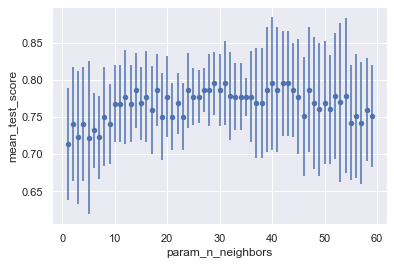

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()
parameters = {"n_neighbors" : range(1, 60)}
clf = GridSearchCV(model, parameters).fit(train_X, train_y)

cv_results = DataFrame(clf.cv_results_)
cv_results = cv_results.sort_values(["rank_test_score", "mean_test_score"])
cv_results.plot.scatter("param_n_neighbors", "mean_test_score", yerr="std_test_score")

/var/folders/9q/486czkcn7lv5v0hwbt71twdc0000gn/T/ipykernel_1481/1106126794.py:17: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.pcolormesh(grid_x1_values, grid_x2_values, y_hat, cmap="Pastel2", alpha=1.0, shading="auto")


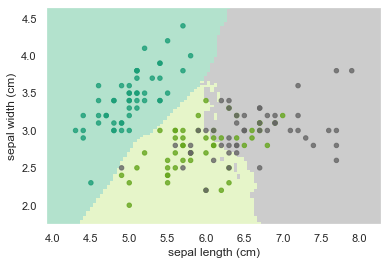

In [28]:
def plot_knn(model, X, y, resolution=100, ax=None):
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    x1 = X.iloc[:,0]
    x2 = X.iloc[:,1]
    x1_range = np.linspace(x1.min()*1.1 - x1.max()*0.1, x1.max()*1.1 - x1.min()*0.1, resolution)
    x2_range = np.linspace(x2.min()*1.1 - x2.max()*0.1, x2.max()*1.1 - x2.min()*0.1, resolution)
    grid_x1_values, grid_x2_values = np.meshgrid(x1_range, x2_range)
    x_prime = np.column_stack((grid_x1_values.ravel(), grid_x2_values.ravel()))
    x_prime = pd.DataFrame(x_prime, columns=X.columns)
    y_hat = model.predict(x_prime).reshape(grid_x1_values.shape)

    if ax is None:
        fig, ax = plt.subplots()
    ax.pcolormesh(grid_x1_values, grid_x2_values, y_hat, cmap="Pastel2", alpha=1.0, shading="auto")
    X.plot.scatter(0, 1, c=y, colormap="Dark2", colorbar=False, alpha=0.8, ax=ax)

plot_knn(clf, X, y)

In [29]:
clf.score(test_X, test_y)

0.868421052631579

### Project 2

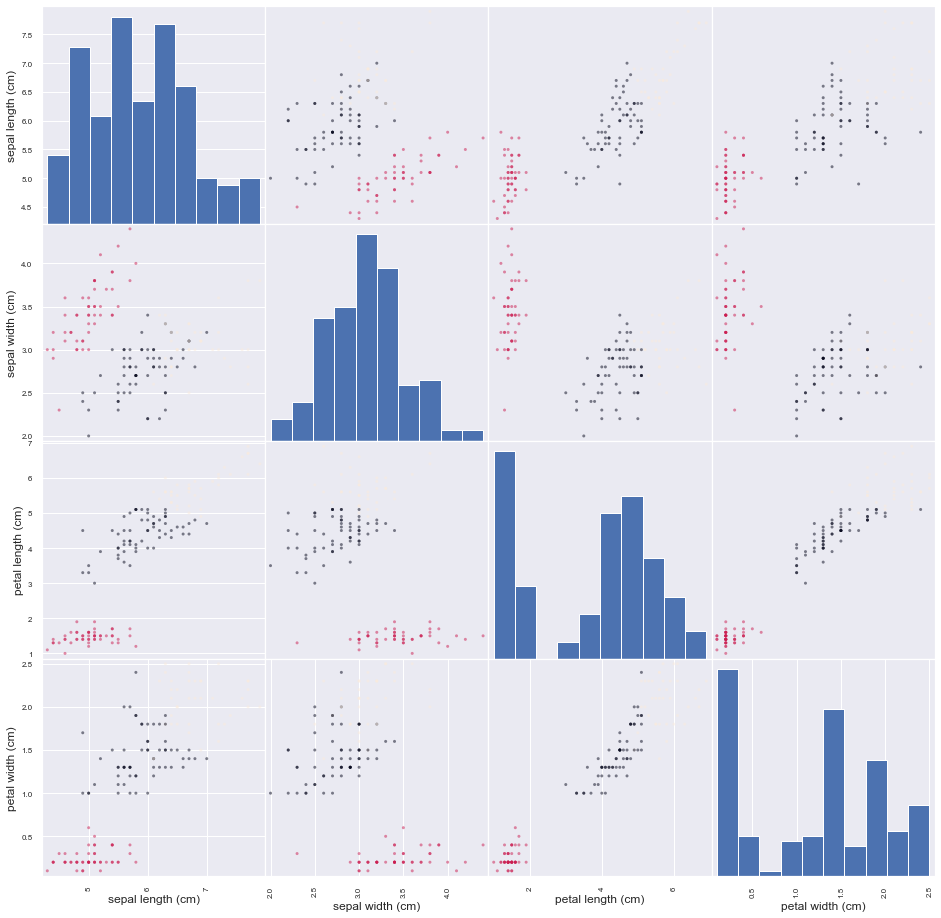

In [30]:
from pandas import DataFrame
from pandas.plotting import scatter_matrix
from sklearn.cluster import KMeans
from sklearn.datasets import load_iris

iris = DataFrame(load_iris().data, columns=load_iris().feature_names)
num_iris_species = len(load_iris().target_names)
kmeans = KMeans(n_clusters=num_iris_species).fit(iris)
a = scatter_matrix(iris, figsize=(16, 16), c=kmeans.labels_)

### Project 3

<AxesSubplot:>

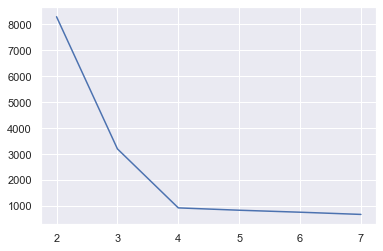

In [31]:
from pandas import Series, DataFrame
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

data, true_labels = make_blobs(n_samples=500, centers=4, random_state=6)
points = DataFrame(data, columns=["x", "y"])

inertia_values = []
r = pd.RangeIndex(2, 8)
for n_clusters in r:
    kmeans = KMeans(n_clusters=n_clusters).fit(points)
    inertia_values.append(kmeans.inertia_)

inertia = Series(inertia_values, name="inertia", index=r)
inertia.plot()